## Assigment 2
#### In this assigment you are handed (you download) a dataset and perform ML on it.

In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".99"})

### Go and participate into the Kaggle competition, [titanic](https://www.kaggle.com/c/titanic)
Get the data or work there, however - and start to explore what kind of information you can extract. Under you find some questions that ought to make the task easier, but you can figure out interesting ones yourselves. Try to build understanding on who were likely to survive. 
***
We shall not do much statistics here and you can omit confidence intervals etc., the probability for survival in group of people $G$ can be expressed as:

$
p_\text{survival}(G) = \frac{n_\text{survived}}{|G|} = \frac{1}{|G|} \sum_{i \in G} S_i,
$

where $|G|$ is the number of people in group $G$ and $S_i$ is the Survived column value ({0, 1}) of person i. 

In [3]:
# https://www.kaggle.com/c/titanic
from sklearn.impute import SimpleImputer, _base
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

random_state = 42

filler = ColumnTransformer(
            [('const', SimpleImputer(strategy='constant', fill_value='missing'), ['Cabin', 'Embarked', 'Sex']),
             ('mean', SimpleImputer(strategy='mean'), ['Age', 'Fare']),
             ('pass', 'passthrough', ['Pclass', 'Sibsp', 'Parch'])])


# Store the features here, since they are needed later:
features = np.array(['Cabin', 'Embarked', 'Sex', 'Age', 'Fare', 'Pclass', 'Sibsp', 'Parch'])

def handle_cabin(data):
    
    def __map_cabin(cabin):
        if isinstance(cabin, float):
            if np.isnan(cabin): 
                return 0
        elif isinstance(cabin, int):
            return cabin
        elif isinstance(cabin, str):
            for i, cclass in enumerate('ABCDEFG'):
                if cabin.startswith(cclass): 
                    return i+1
            return -1
        elif cabin is None: 
            return 0
    
    return data.Cabin.apply(__map_cabin, convert_dtype=True)

def get_data():
    X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
    X = X.drop(columns=['boat', 'home.dest', 'body', 'name', 'ticket'])
    
    X.columns = [c[0].upper() + c[1:] for c in X.columns]
    y.name = 'Survived'
    y = y.astype(int)
    
    dtype_dict = {'Pclass':int,
                  'Parch':int, 
                  'Sibsp':int, 
                  'Sex':'category',
                  'Cabin':'category',
                  'Embarked':'category',
                  'Age':float,
                  'Fare':float} 
 
    X.Cabin = handle_cabin(X)
    
    X = filler.fit_transform(X)
    
    X = pd.DataFrame(data=X, columns=features).astype(dtype_dict)
    
    return train_test_split(X, y, random_state=random_state)
    
    return X, 
    
X, X_test, y, y_test = get_data()
data = pd.concat((X, y), axis=1)
data.head()

,Cabin,Embarked,Sex,Age,Fare,Pclass,Sibsp,Parch,Survived
1139,0,S,male,38.0,7.8958,3,0,0,0
678,0,C,male,6.0,15.2458,3,1,1,0
290,5,S,male,52.0,79.6500,1,1,1,0
285,3,S,male,67.0,221.7792,1,1,0,0
1157,0,S,male,18.0,20.2125,3,1,1,0


#### Is there some missing data that ought to be filled. How would you fill the different columns? Do you think some of them could be discarted already now? Make a preprocessing pipe to which one can give data and its gives back processed (missing values filled, catecorigal features encoded to numerical ones) DataFrame.

In [4]:
def check_data(data):
    b = pd.DataFrame()
    b['count null'] = data.isnull().sum(axis=0) 
    b['count unique'] = data.nunique()
    b['dtype'] = data.dtypes
    display(b)
    
check_data(data)

,count null,count unique,dtype
Cabin,0,9,category
Embarked,0,4,category
Sex,0,2,category
Age,0,93,float64
Fare,0,253,float64
Pclass,0,3,int64
Sibsp,0,7,int64
Parch,0,8,int64
Survived,0,2,int64


## Start exploring:
***

#### What are the age distributions? (Maybe sns.violinplot or sns.boxplot)

<AxesSubplot:xlabel='Sex', ylabel='Age'>

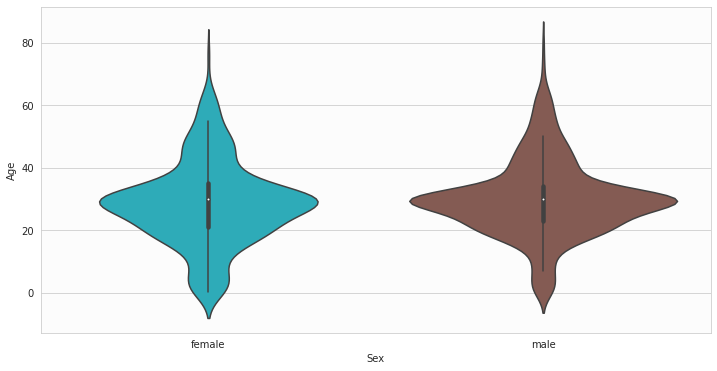

In [51]:
sex_palette={'male':'C5', 'female':'C9'}

sns.violinplot(x='Sex', y='Age', data=data, palette=sex_palette)

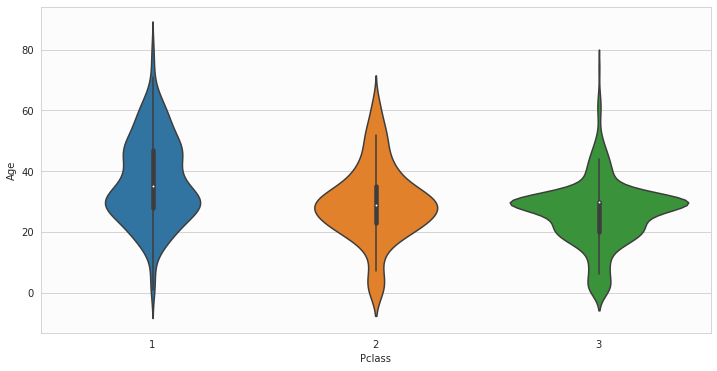

In [54]:
_ = sns.violinplot(x='Pclass', y='Age', data=data)

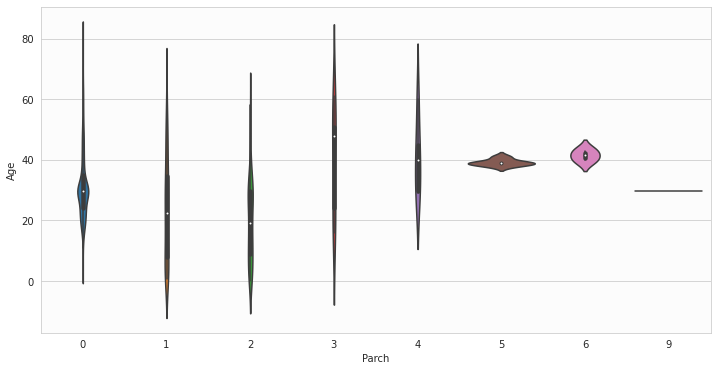

In [55]:
_ = sns.violinplot(x='Parch', y='Age', data=data)

#### Number of tickest sold in different fare classes? (sns.histplot)

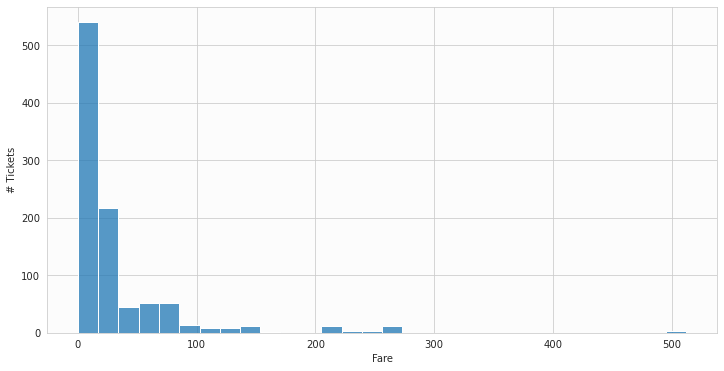

In [5]:
ax = sns.histplot(data.Fare, bins=30, kde=False)
_ = ax.set_ylabel('# Tickets')

#### How does survival probabilty depend on the ticket class and age of passanger? (sns.barplot)

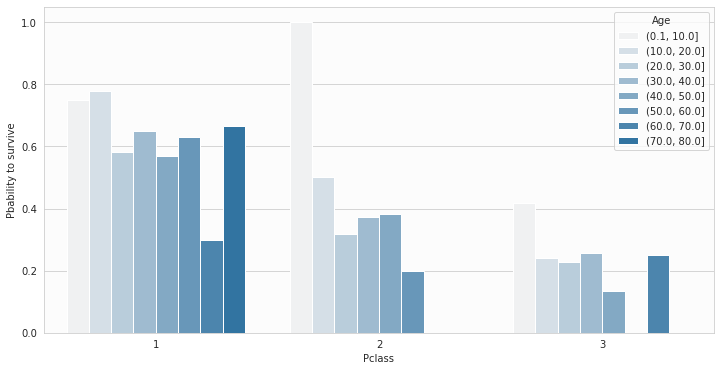

In [6]:
ci = None #90 #
ax = sns.barplot(x=data.Pclass, 
                 y=data.Survived, 
                 hue=pd.cut(data.Age, 8, precision=0),        
                 color='C0', capsize=.03, errwidth=2, ci=ci)

_ = ax.set_ylabel('Pbability to survive')

#### Can you figure out the amount of survived/died people by age? 

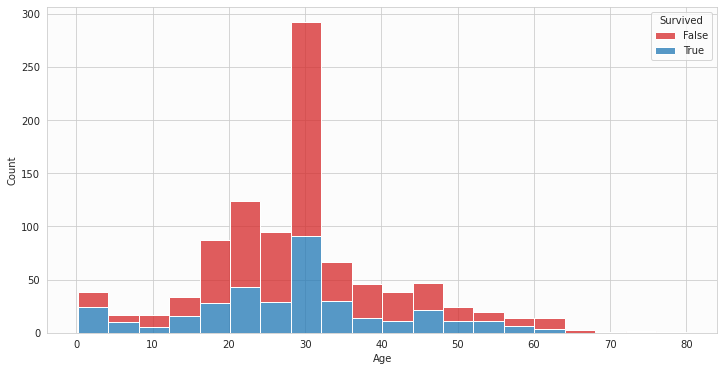

In [46]:
survived_palette = {0:'C3', 1:'C0'}

ax = sns.histplot(x=data.Age, hue=data.Survived.astype(bool), 
                  bins=20, 
                  palette=survived_palette, 
                  multiple='stack')


#### Is there some differences in survival probabilities between sexes in different age groups?

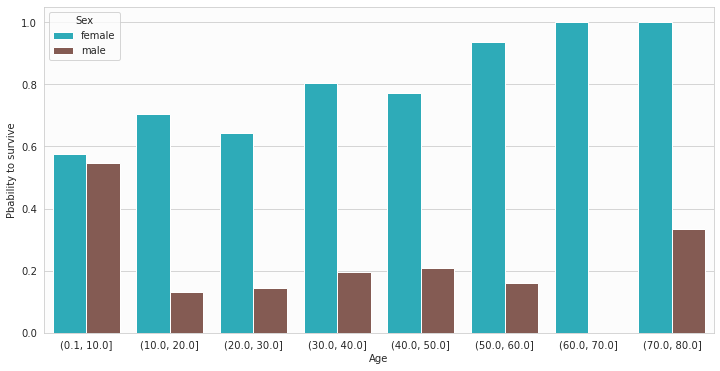

In [56]:
ax = sns.barplot(x=pd.cut(data.Age, 8, precision=0), 
                 y=data.Survived, 
                 hue=data.Sex, palette=sex_palette,
                 color='C0', capsize=.03, errwidth=2, ci=ci)
_ = ax.set_ylabel('Pbability to survive')

#### How does the Sex affect the survival probability in different fare classes?

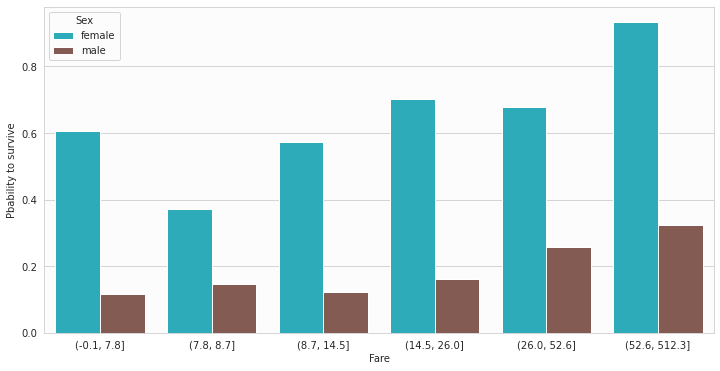

In [57]:
ax = sns.barplot(x=pd.qcut(data.Fare, 6, precision=1), 
                 y=data.Survived, 
                 hue=data.Sex, palette=sex_palette,
                 color='C0', capsize=.03, errwidth=2, ci=ci)
_ = ax.set_ylabel('Pbability to survive')

#### How about age?

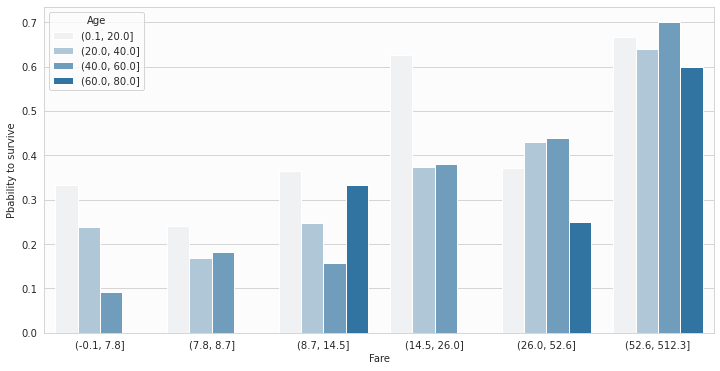

In [58]:
ax = sns.barplot(x=pd.qcut(data.Fare, 6, precision=1), 
                 y=data.Survived, 
                 hue=pd.cut(data.Age, 4, precision=0), 
                 color='C0', capsize=.03, errwidth=2, ci=ci)
_ = ax.set_ylabel('Pbability to survive')

#### How does different numerical features correlate in the training data?

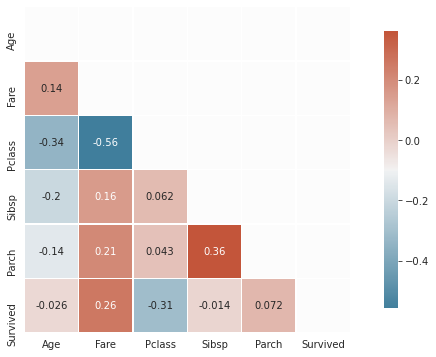

In [59]:
corr = data.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
_ = sns.heatmap(corr, 
                cmap=cmap, 
                square=True, 
                linewidths=.5, 
                annot=True, 
                mask=mask, 
                cbar_kws={"shrink": .85})

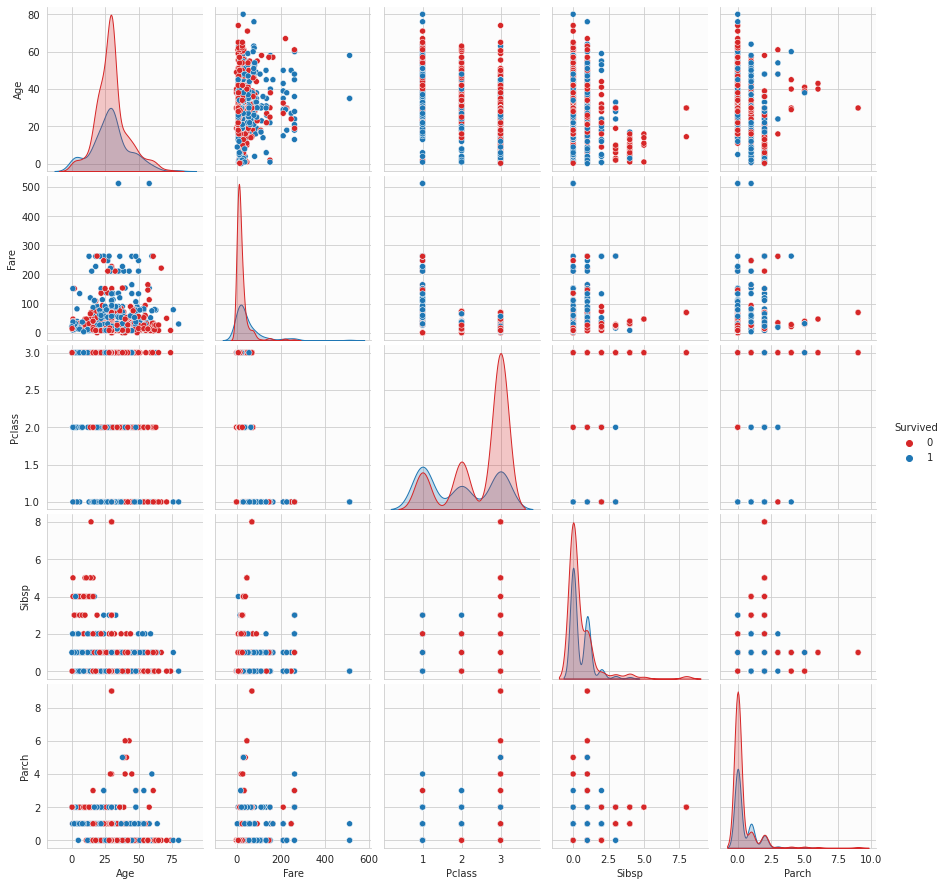

In [60]:
survived_palette = {0:'C3', 1:'C0'}
ax = sns.pairplot(data, hue='Survived', palette=survived_palette)

## Start modeling:
***
#### Perform train test splitting:

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector



X_train, X_test, y_train, y_test = get_data() 

display(X_train.head())
y_train.head()

,Cabin,Embarked,Sex,Age,Fare,Pclass,Sibsp,Parch
1139,0,S,male,38.0,7.8958,3,0,0
678,0,C,male,6.0,15.2458,3,1,1
290,5,S,male,52.0,79.6500,1,1,1
285,3,S,male,67.0,221.7792,1,1,0
1157,0,S,male,18.0,20.2125,3,1,1


1139    0
678     0
290     0
285     0
1157    0
Name: Survived, dtype: int64

In [27]:
encoder = ColumnTransformer([('cat', OrdinalEncoder(), make_column_selector(dtype_include=['category', object]))],
                              remainder='passthrough')
scaler = Pipeline([('encode', encoder), ('scale', StandardScaler())])


# Use the pipes to preprocess the daat into two possible formats:
X_train_enc = pd.DataFrame(data=encoder.fit_transform(X_train), columns=[f+'_enc' for f in features]) #pd.DataFrame(data=enc_data, columns=[f+'_enc' for f in features])
X_test_enc = pd.DataFrame(data=encoder.transform(X_test), columns=[f+'_enc' for f in features])

X_train_sc = pd.DataFrame(data=scaler.fit_transform(X_train), columns=[f+'_sc' for f in features])
X_test_sc = pd.DataFrame(data=scaler.transform(X_test), columns=[f+'_sc' for f in features])


display(X_train_enc.head())
display(X_train_sc.head())

,Cabin_enc,Embarked_enc,Sex_enc,Age_enc,Fare_enc,Pclass_enc,Sibsp_enc,Parch_enc
0,1.0,2.0,1.0,38.0,7.8958,3.0,0.0,0.0
1,1.0,0.0,1.0,6.0,15.2458,3.0,1.0,1.0
2,6.0,2.0,1.0,52.0,79.6500,1.0,1.0,1.0
3,4.0,2.0,1.0,67.0,221.7792,1.0,1.0,0.0
4,1.0,2.0,1.0,18.0,20.2125,3.0,1.0,1.0


,Cabin_sc,Embarked_sc,Sex_sc,Age_sc,Fare_sc,Pclass_sc,Sibsp_sc,Parch_sc
0,-0.479307,0.615281,0.74146,0.675817,-0.491838,0.836547,-0.498313,-0.433006
1,-0.479307,-1.858452,0.74146,-1.854980,-0.351668,0.836547,0.439969,0.673189
2,2.758984,0.615281,0.74146,1.783041,0.876563,-1.549072,0.439969,0.673189
3,1.463668,0.615281,0.74146,2.969352,3.587061,-1.549072,0.439969,-0.433006
4,-0.479307,0.615281,0.74146,-0.905931,-0.256950,0.836547,0.439969,0.673189


#### Do classification: 

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=random_state) #.fit(X_train, y_train)

grid_params = {'max_depth':np.arange(50,301,50), 'n_estimators':[10, 50, 100, 300]}
grid = GridSearchCV(rf, grid_params, scoring='accuracy', cv=3).fit(X_train_enc, y_train)
rf_best = grid.best_estimator_

tree = DecisionTreeClassifier(random_state=random_state).fit(X_train_enc, y_train)
lgreg = LogisticRegression().fit(X_train_sc, y_train)

#### Based on the exploration phase make a dummy classifier, that you ought to definitely beat using more elaborate methods:

In [29]:
def dummy_clf(sexarr): 
    return (sexarr == 'female') 

#### Evaluate the performance of your classifier:

In [30]:
from sklearn.metrics import classification_report

print('Dummy clf:')
print(classification_report(y_test, dummy_clf(X_test.Sex), digits=4))
print('Tree clf:')
print(classification_report(y_test, tree.predict(X_test_enc), digits=4))
print('RF clf:')
print(classification_report(y_test, rf_best.predict(X_test_enc), digits=4))
print('LogisticRegression clf:')
print(classification_report(y_test, lgreg.predict(X_test_sc), digits=4))

Dummy clf:
              precision    recall  f1-score   support

           0     0.7667    0.8750    0.8173       184
           1     0.8051    0.6597    0.7252       144

    accuracy                         0.7805       328
   macro avg     0.7859    0.7674    0.7712       328
weighted avg     0.7835    0.7805    0.7768       328

Tree clf:
              precision    recall  f1-score   support

           0     0.7487    0.7935    0.7704       184
           1     0.7143    0.6597    0.6859       144

    accuracy                         0.7348       328
   macro avg     0.7315    0.7266    0.7282       328
weighted avg     0.7336    0.7348    0.7333       328

RF clf:
              precision    recall  f1-score   support

           0     0.7783    0.8587    0.8165       184
           1     0.7920    0.6875    0.7361       144

    accuracy                         0.7835       328
   macro avg     0.7852    0.7731    0.7763       328
weighted avg     0.7843    0.7835    0.7812  

### Consider the feature importances:

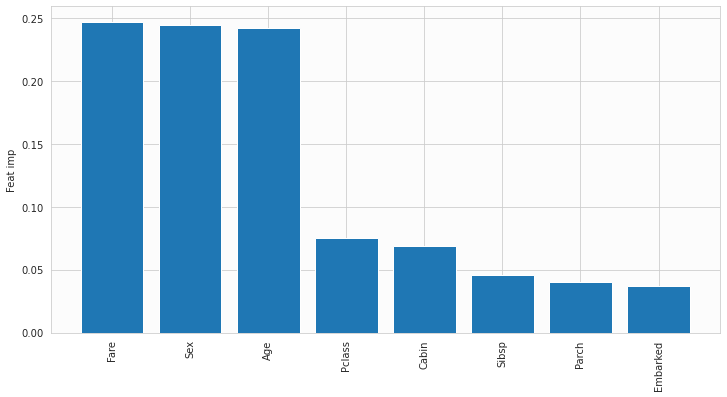

In [31]:
def plot_feat_imp(features, feat_imp):
    
    _, ax = plt.subplots()
    sort_idx = np.absolute(feat_imp).argsort()[::-1].astype(int)
    
    if not isinstance(features, np.ndarray):
        features = np.array(features)
        
    xticks = np.arange(len(feat_imp))
    ax.bar(xticks, feat_imp[sort_idx].astype(float))
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels=features[sort_idx], rotation=90)
    ax.set_ylabel('Feat imp')
    plt.show()
    

plot_feat_imp(features, rf_best.feature_importances_)

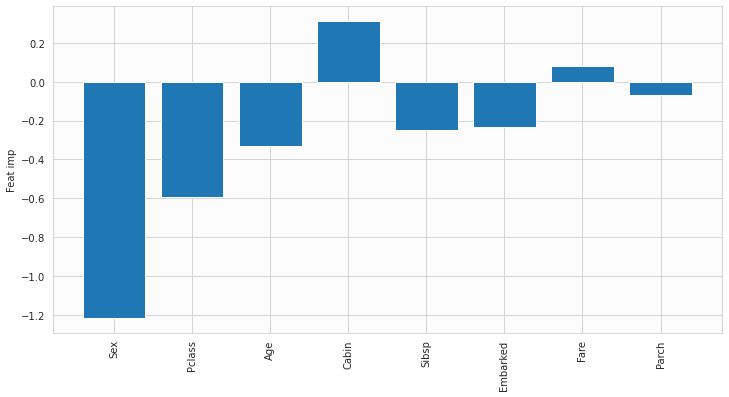

In [32]:
plot_feat_imp(features, lgreg.coef_[0])

In [33]:
from sklearn.metrics import accuracy_score

def report_clf(subfeatures, clf):
    
    subfeatures = [f + '_sc' for f in subfeatures]
    
    clf.fit(X_train_sc.loc[:, subfeatures], y_train)
    print('Accuracy: {:.4f}'.format(accuracy_score(y_test, 
                                                   clf.predict(X_test_sc.loc[:, subfeatures]))))
    print()

In [34]:
feat_imp = rf_best.feature_importances_
sorted_feat = features[np.absolute(feat_imp).argsort()][::-1]
for i in range(1,len(sorted_feat)+1):
    print('{} - Nfeat {}:'.format(rf, i))
    print(*sorted_feat[:i], end='--> \n')
    report_clf(sorted_feat[:i], rf)

RandomForestClassifier(random_state=42) - Nfeat 1:
Fare--> 
Accuracy: 0.6433

RandomForestClassifier(random_state=42) - Nfeat 2:
Fare Sex--> 
Accuracy: 0.7530

RandomForestClassifier(random_state=42) - Nfeat 3:
Fare Sex Age--> 
Accuracy: 0.7835

RandomForestClassifier(random_state=42) - Nfeat 4:
Fare Sex Age Pclass--> 
Accuracy: 0.8140

RandomForestClassifier(random_state=42) - Nfeat 5:
Fare Sex Age Pclass Cabin--> 
Accuracy: 0.7957

RandomForestClassifier(random_state=42) - Nfeat 6:
Fare Sex Age Pclass Cabin Sibsp--> 
Accuracy: 0.7957

RandomForestClassifier(random_state=42) - Nfeat 7:
Fare Sex Age Pclass Cabin Sibsp Parch--> 
Accuracy: 0.7805

RandomForestClassifier(random_state=42) - Nfeat 8:
Fare Sex Age Pclass Cabin Sibsp Parch Embarked--> 
Accuracy: 0.7713



In [35]:
sorted_feat = features[np.absolute(lgreg.coef_[0]).argsort()][::-1]
for i in range(1,len(sorted_feat)+1):
    print('{} - Nfeat {}:'.format(lgreg, i))
    print(*sorted_feat[:i], end='--> \n')
    report_clf(sorted_feat[:i], lgreg)

LogisticRegression() - Nfeat 1:
Sex--> 
Accuracy: 0.7805

LogisticRegression() - Nfeat 2:
Sex Pclass--> 
Accuracy: 0.7805

LogisticRegression() - Nfeat 3:
Sex Pclass Age--> 
Accuracy: 0.7957

LogisticRegression() - Nfeat 4:
Sex Pclass Age Cabin--> 
Accuracy: 0.8079

LogisticRegression() - Nfeat 5:
Sex Pclass Age Cabin Sibsp--> 
Accuracy: 0.7988

LogisticRegression() - Nfeat 6:
Sex Pclass Age Cabin Sibsp Embarked--> 
Accuracy: 0.8049

LogisticRegression() - Nfeat 7:
Sex Pclass Age Cabin Sibsp Embarked Fare--> 
Accuracy: 0.8049

LogisticRegression() - Nfeat 8:
Sex Pclass Age Cabin Sibsp Embarked Fare Parch--> 
Accuracy: 0.8079



In [36]:
from sklearn.metrics import accuracy_score

lgreg.fit(X_train_sc, y_train)
print(accuracy_score(y_test, lgreg.predict(X_test_sc)))

0.8079268292682927
